
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

from beacs.agents.beacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from beacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "Woods100-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_ALP = 0.05
BETA_RL = 0.05
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#BEACS Set Up
DO_GA = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 1
INITIAL_SPREAD = 0.1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ □ $ A ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES,
    spread=INITIAL_SPREAD
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 6.13 s, sys: 65.6 ms, total: 6.19 s
Wall time: 8.8 s


### Performance

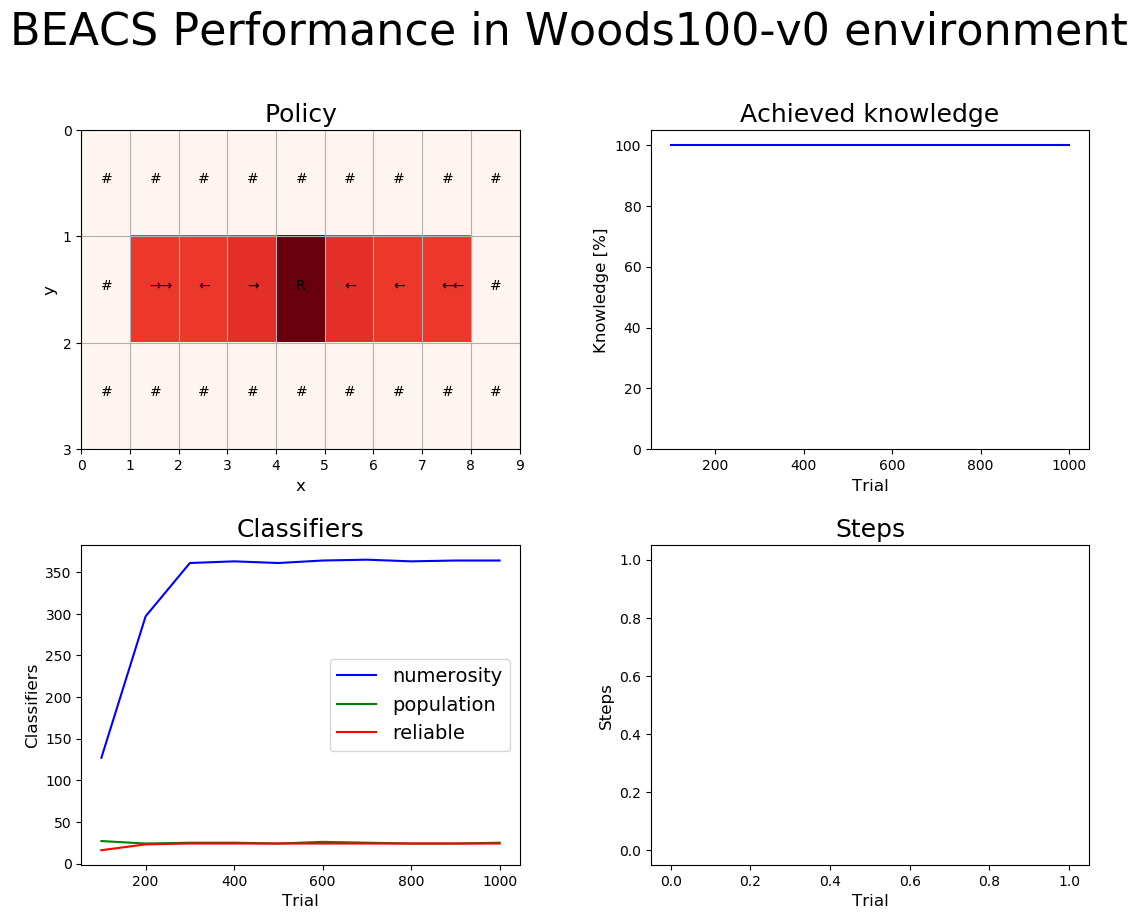

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze, cfg_explore))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze, cfg_explore),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

#old_error, new_error = _enhanced_effect_error(population_explore, maze, cfg_explore, RANDOM_ATTRIBUTE_LENGTH)
#print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}
Full knowledge was achieved at trials  100 , was stable at  100  and the last time it was achieved at  1000
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.8333333333333334
{'trial': 1000, 'steps_in_trial': 11, 'reward': 1000, 'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore
    if cl.is_enhanced()]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

##[-0.05;0.05]###[-0.05;0.05]# 6 None (######[8.95;9.05]#:#499, ######[0.95;1.05]#:#472) (empty)
q: 1.0    ra: 924.0  rb: 925.1  ir: 0.0    f: 925.1  err: 24.35 
exp: 970   num: 20 ee: False PAI_state: 
tga: 13070 tbseq: 12777 talp: 13114 tav: 17.66  



##[-0.05;0.05]###[-0.05;0.05]# 2 None (##[8.95;9.05]#####:#377, ##[0.95;1.05]#####:#470) (empty)
q: 1.0    ra: 921.4  rb: 924.4  ir: 0.0    f: 924.4  err: 24.25 
exp: 846   num: 19 ee: False PAI_state: 
tga: 13119 tbseq: 12777 talp: 13119 tav: 15.04  





In [8]:
agent_explore.get_pai_states_memory()

[(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0)]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES,
    spread=INITIAL_SPREAD
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 1.21 s, sys: 6.79 ms, total: 1.21 s
Wall time: 1.26 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES,
    spread=INITIAL_SPREAD
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 1.18 s, sys: 2.01 ms, total: 1.19 s
Wall time: 1.19 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES,
    spread=INITIAL_SPREAD
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 1.21 s, sys: 3.05 ms, total: 1.22 s
Wall time: 1.22 s


### Performance

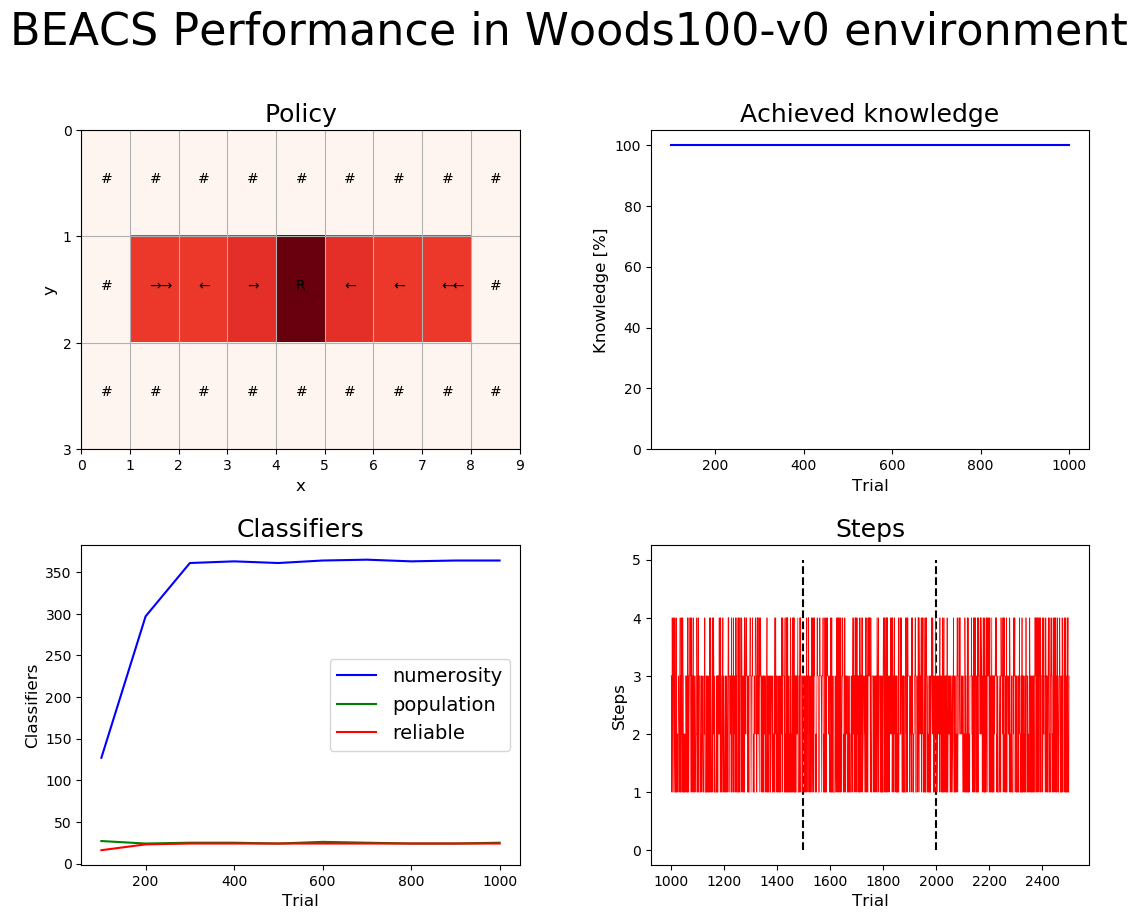

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze, cfg_explore))
print(_maze_metrics(population_exploit_no_rl, maze, cfg_exploit_no_rl))
print(_maze_metrics(population_exploit_rl_start, maze, cfg_exploit_rl_start))
print(_maze_metrics(population_exploit_rl, maze, cfg_exploit_rl))

Average number of steps to solve the maze is  17.0  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  2.236  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  2.292  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  2.328  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}
{'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}
{'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}
{'knowledge': 100.0, 'population': 25, 'numerosity': 364, 'reliable': 24}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")
#from beacs.agents.beacs import ClassifiersList
#print(len(ClassifiersList(*list(dict.fromkeys(population_exploit_rl_to_display)))))

8


######[0.95;1.05]# 2 [2] (##[8.95;9.05]###[-0.05;0.05]#:#1) (empty)
q: 1.0    ra: 950.0  rb: 950.0  ir: 0.0    f: 950.0  err: 3.574e-05
exp: 425   num: 20 ee: False PAI_state: 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0
tga: 13105 tbseq: 1380  talp: 13110 tav: 24.73  



##[0.95;1.05]##### 6 [6] (##[-0.05;0.05]###[8.95;9.05]#:#1) (empty)
q: 1.0    ra: 950.0  rb: 950.0  ir: 0.0    f: 950.0  err: 0.01177
exp: 309   num: 20 ee: False PAI_state: 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0
tga: 13051 tbseq: 1410  talp: 13121 tav: 27.15  



##[8.95;9.05]##### 6 [2] (########:#1) (empty)
q: 1.0    ra: 941.3  rb: 944.1  ir: 0.0    f: 941.3  err: 16.51 
exp: 198   num: 20 ee: False PAI_state: 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0
tga: 13030 tbseq: 1802  talp: 13095 tav: 49.89  



######[8.95;9.05]# 2 [6] (########:#1) (empty)
q: 1.0    ra: 945.6  rb: 940.8  ir: 0.0    f: 940.8  err: 13.19 
exp: 209   num: 20 ee: False PAI_state: 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0
tga: 13072 tbseq: 1475  talp: 